In [1]:
import torch
from torch import nn
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
sys.path.append('../')

import importlib
import sys
from torch.utils.data import  Dataset
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import pytorch_lightning as pl

import pandas as pd
import seaborn as sn
import torch
import numpy as np
from scipy.stats import multivariate_normal
 
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans 

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.covariance import EmpiricalCovariance
from scipy.spatial.distance import mahalanobis
import time
from OpenOODmain.openood.evaluators.metrics  import compute_all_metrics

In [ ]:
import csv
import os
# functions _save_csv and save_table are adapted from https://github.com/Jingkang50/OpenOOD/blob/main/openood/evaluators/ood_evaluator.py
def _save_csv(metrics, dataset_name, output_folder,t,method,file_name = "ood.csv"):
        [fpr, auroc, aupr_in, aupr_out, accuracy] = metrics

        write_content = {
            'method' : method,
            'dataset': dataset_name,
            'FPR@95': '{:.2f}'.format(100 * fpr),
            'AUROC': '{:.2f}'.format(100 * auroc),
            'AUPR_IN': '{:.2f}'.format(100 * aupr_in),
            'AUPR_OUT': '{:.2f}'.format(100 * aupr_out),
            'ACC': '{:.2f}'.format(100 * accuracy),
            "timestep" : '{:.2f}'.format(100 * t)
        }

        fieldnames = list(write_content.keys())

        # print ood metric results
        print('FPR@95: {:.2f}, AUROC: {:.2f}'.format(100 * fpr, 100 * auroc),
              end=' ',
              flush=True)
        print('AUPR_IN: {:.2f}, AUPR_OUT: {:.2f}'.format(
            100 * aupr_in, 100 * aupr_out),
              flush=True)
        print('ACC: {:.2f}'.format(accuracy * 100), flush=True)
        print(u'\u2500' * 70, flush=True)

        csv_path = os.path.join(output_folder, file_name)
        if not os.path.exists(csv_path):
            with open(csv_path, 'w', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerow(write_content)
        else:
            with open(csv_path, 'a', newline='') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writerow(write_content)

def save_table(path):
    df = pd.read_csv(f'{path}/ood.csv')
    # Filter out rows where ACC is 0 or 100
    df_filtered = df[(df['ACC'] != 0) & (df['ACC'] != 100)]
    # For each dataset, pick the row with the highest AUROC
    best_rows = df_filtered.loc[df_filtered.groupby('dataset')['AUROC'].idxmax()]
    # Reset index for clarity
    best_rows.reset_index(drop=True, inplace=True)
    # Display the resulting table
    print(best_rows)
    # Optionally save the result to a new CSV
    best_rows.to_csv('highest_auroc_per_dataset.csv', index=False)


In [3]:
# Functions for representation normalization
def denormalize(normalized, basis):
    return basis.min() + (basis.max() - basis.min())*((normalized + 1)/2)

def normalize(unnormalized, basis):
    return (2 * (unnormalized - basis.min()) / (basis.max() - basis.min()) - 1)

def normalize_feat_wise(unnormalized, basis):
    return (2 * (unnormalized - basis.min(0)) / (basis.max(0) - basis.min(0)) - 1)

def denormalize_feat_wise(normalized, basis):
    return basis.min(0) + (basis.max(0) - basis.min(0))*((normalized + 1)/2)

def denormalize_std(normalized, basis):
    return normalized * basis.std(0) + basis.mean(0)

def normalize_std(unnormalized, basis):
    return (unnormalized - basis.mean(0))/basis.std(0)



Here follows the hyperparameter-tuning for baseline methods

In [175]:
ind_name = "imagenet200"
ind_tags= ["train", "test"]

#ood_tags =  ["cifar10", "tin", "mnist","svhn","texture", "places365"] #................................
ood_tags =  ["cifar100", "tin", "mnist", "svhn","texture", "places365" ]
#ood_tags = ["ssb_hard","ninco", "inaturalist", "textures", "openimageo"]

#load the activations
test_acts = np.load(f"./logs_jl/vdm_open/{ind_name}_acts/resnet18_{ind_name}_test.npy")
train_acts = np.load(f"./logs_jl/vdm_open/{ind_name}_acts/resnet18_{ind_name}_train.npy")
test_targets = np.load(f"./logs_jl/vdm_open/{ind_name}_acts/resnet18_{ind_name}_test_y.npy")
train_targets= np.load(f"./logs_jl/vdm_open/{ind_name}_acts/resnet18_{ind_name}_train_y.npy")

################# normed per feature
train_acts_normed =normalize_std(train_acts,train_acts)
test_acts_normed = normalize_std(test_acts ,train_acts)



In [ ]:
np.random.seed(0)

# Downsample to 10K training samples for practical GMM/KDE fitting
np.random.shuffle(train_acts_normed)
X_train_small = train_acts_normed[:10_000]
X_val =   train_acts_normed[10_000:]

In [ ]:
class DiagonalGaussian:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)

    def score_samples(self, X):
        return -0.5 * np.sum(((X - self.mean) / self.std) ** 2 + np.log(2 * np.pi * self.std ** 2), axis=1)
gaussian = DiagonalGaussian()
gaussian.fit(train_acts_normed)
gaussian.score_samples(test_acts_normed)

array([-896.582, -721.531, -701.869, ..., -668.742, -774.579, -941.145],
      shape=(9000,), dtype=float32)

In [ ]:
# 2. Diagonal GMM (hyperparameter tuning on n_components)
best_gmm_score = -np.inf
best_gmm_model = None
gmm_scores = []
nr_components = np.arange(10,250,10)
for n in nr_components:
    gmm = GaussianMixture(n_components=n, covariance_type='diag', random_state=42)
    print(n)
    gmm.fit(X_train_small)
    score = gmm.score(X_val)
    if score > best_gmm_score:
        best_gmm_score = score
        best_gmm_model = gmm
    gmm_scores.append(score)

In [ ]:
plt.plot(nr_components,gmm_scores)

In [ ]:
# 3. Mahalanobis Distance (using shared covariance)
cov_estimator = EmpiricalCovariance().fit(X_train_small)
mean_mahal = X_train_small.mean(axis=0)
inv_cov = np.linalg.inv(cov_estimator.covariance_)
mahal_distances = np.array([mahalanobis(x, mean_mahal, inv_cov) for x in test_acts_normed[:1000]])
mahal_distances


class MahalanobisModel:
    def __init__(self):
        self.mean = None
        self.inv_cov = None

    def fit(self, X):
        cov_estimator = EmpiricalCovariance().fit(X)
        self.mean = X.mean(axis=0)
        self.inv_cov = np.linalg.inv(cov_estimator.covariance_)

    def score_samples(self, X):
        distances = np.array([mahalanobis(x, self.mean, self.inv_cov) for x in X])
        return -0.5 * distances **2

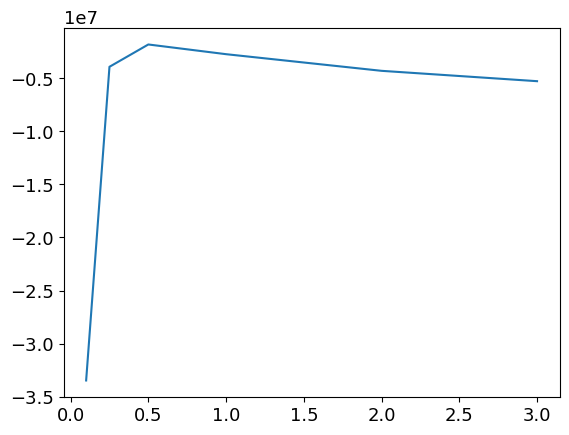

In [ ]:
# 4. KDE with bandwidth tuning
best_kde_score = -np.inf
best_kde_model = None
kde_score = []
bws = [0.1,0.25, 0.5,1.0,2.0,3.0]
for bw in bws:
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(X_train_small)
    score = kde.score(X_val)
    if score > best_kde_score:
        best_kde_score = score
        best_kde_model = kde
    kde_score.append(score)

plt.plot(bws, kde_score)


Here follows the testing

In [ ]:
blue ="#1f77b4"
green = "#2ca02c"
red = "#ff7f0e"
tr = "train"
te = "test"
ood = "OOD"


def tester_func(ind_name, ood_tags, model, train_acts, method ="GMM",s_version = "",file_name = "ood.csv"):
    ''' A function to draw the figures over OOD and TEST scores
    '''
    test_acts = np.load(f"./logs_jl/vdm_open/{ind_name}_acts{s_version}/resnet18_{ind_name}_test.npy")
    test_acts_normed = normalize_std(test_acts ,train_acts)
    test_targets = np.load(f"./logs_jl/vdm_open/{ind_name}_acts{s_version}/resnet18_{ind_name}_test_y.npy")
    test_softs = np.load(f"./logs_jl/vdm_open/{ind_name}_acts{s_version}/resnet18_{ind_name}_test_softs.npy")
    output_folder =  f"./LDM_tests/results_{ind_name}_baselines"

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    plt.rcParams.update({
            'font.size': 12,          # base font size
            'axes.titlesize': 14,     # title font size
            'axes.labelsize': 14,     # x– and y–label font size
            'xtick.labelsize': 13,    # tick label font size
            'ytick.labelsize': 13,    # tick label font size
            'legend.fontsize': 14,    # legend font size
            'figure.titlesize': 16    # figure title
        })
    axs = axs.flatten()  # flatten to simplify indexing


    if not os.path.exists(output_folder):
            # Create the folder (including any necessary parent directories)
            os.makedirs(output_folder)
            print(f"Folder created: {output_folder}")
    else:
        print(f"Folder already exists: {output_folder}")
    model_test = model.score_samples(test_acts_normed)


    for i, ood_tag in enumerate(ood_tags):
        ood_acts = np.load(f"./logs_jl/vdm_open/{ind_name}_acts{s_version}/resnet18_{ind_name}_{ood_tag}.npy")
        ood_targets= np.load(f"./logs_jl/vdm_open/{ind_name}_acts{s_version}/resnet18_{ind_name}_{ood_tag}_y.npy")
        ood_acts_normed = normalize_std(ood_acts ,train_acts)
        ood_softs = np.load(f"./logs_jl/vdm_open/{ind_name}_acts{s_version}/resnet18_{ind_name}_{ood_tag}_softs.npy")
        labels = np.concatenate([test_targets, ood_targets])
        pred = np.concatenate([test_softs.argmax(1), ood_softs.argmax(1)])    

        model_ood = model.score_samples(ood_acts_normed)
        total_distances = np.concatenate([model_test, model_ood])

        results = compute_all_metrics(total_distances, labels, pred)
        auc =results[1].round(3)
        if results[1].round(3) < 0.5:
            auc = (1- auc).round(3)
        print(auc)

        ax = axs[i]
        ax.hist(model_test, bins=100, alpha=0.5, density=True, label=te,color = green)
        ax.hist(model_ood, bins=100, alpha=0.5, density=True, label=ood,color = red)
        ax.set_title(f"OOD dataset: {ood_tag}" + "; AUROC = " + str(auc) )
        ax.set_xlabel("Density")   # ← X‐axis label
        ax.set_ylabel("Log-likelihood")
        ax.legend()
        _save_csv(results, ood_tag, output_folder, 0, method,file_name = file_name)

    if ind_name == "cif10":
        title_name = "CIFAR-10"
    elif ind_name == "cif100":
        title_name = "CIFAR-100"
    else:
        title_name = "ImageNet200"

    plt.suptitle(f"Baseline Density-Estimation Method = {method}")
    plt.savefig(f"{output_folder}/baseline_{ind_name}_{method}_{s_version}.png", dpi=300)
    plt.clf()
    plt.close()


In [ ]:
## a training and drawing pipeline

ood_tags= {"cif100": ["cifar10", "tin", "mnist","svhn","texture", "places365"],
"cif10": ["cifar100", "tin", "mnist", "svhn","texture", "places365" ],
 "imagenet200": ["ssb_hard","ninco", "inaturalist", "textures", "openimageo"] }

#hyper_dict = {"cif10": (91,0.1), "cif100" : (116,0.5),"imagenet200" : (220,0.5)}
#hyper_dict = {"cif10": (120,0.1), "cif100" : (110,0.5),"imagenet200" : (250,0.5)}
hyper_dict = {"cif10": (30,0.1), "cif100" : (20,0.5),"imagenet200" : (50,0.5)}



s_version = "_s2"#_s2,_s1

ind_names = ["cif100","cif10","imagenet200"]

for ind_name in ind_names:

    train_acts = np.load(f"./logs_jl/vdm_open/{ind_name}_acts{s_version}/resnet18_{ind_name}_train.npy")
    train_acts_normed =normalize_std(train_acts,train_acts)
    X_train_small = train_acts_normed[np.random.randint(0,50000,5000)]

    print("Fitting gaussian")
    gaussian = DiagonalGaussian()
    gaussian.fit(train_acts_normed)
    print("Fitting mahal")

    mahal = MahalanobisModel()
    mahal.fit(train_acts_normed)
    print("Fitting kde")

    kde_best = KernelDensity(kernel='gaussian',bandwidth=hyper_dict[ind_name][1])
    kde_best.fit(X_train_small)

    print("Fitting gmm")
    start_time = time.time()
    gmm_best = GaussianMixture(n_components=hyper_dict[ind_name][0], covariance_type='diag', random_state=42).fit(train_acts_normed)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"GMM fitting took {elapsed_time:.2f} seconds")
    print("all fit")

    models = [gaussian ,gmm_best, mahal, kde_best]
    methods = ["Gaussian", "GMM", "Mahalanobis", "KDE"]

    for method, mdl in zip(methods,models):
        tester_func(ind_name, ood_tags[ind_name], mdl, train_acts_normed,method,s_version,file_name = "ood.csv")


In [ ]:
import pandas as pd

# --- 1. load -----------------------------
# ------------------------------------
ind_name = "imagenet200"
df = pd.read_csv(f"./LDM_tests/results_{ind_name}_baselines/ood.csv")          # <- path to your file


metrics_wanted = ["FPR@95", "AUROC"]

# 2. ------------- reshape to long -------------------------------------------
long = (
    df.melt(
        id_vars=["method", "dataset"],
        value_vars=metrics_wanted,
        var_name="metric",
        value_name="value"
    )
)
# --- 2b. average over each method-dataset pair -------------------------------
long = (
    long.groupby(["method", "dataset","metric"], as_index=False)
        .mean()
)

def flip_auroc(row):
    if row["metric"] == "AUROC" and row["value"] < 50:
        row["value"] = 100 - row["value"]
    return row

long = long.apply(flip_auroc, axis=1)



# 3. ------------- pivot to wide ---------------------------------------------
report = (
    long.pivot_table(
        index=["method", "metric"],
        columns="dataset",
        values="value"
    )
)


# 4. ------------- enforce column order & drop extras -------------------------
#    – keep only columns that appear in ood_tags AND in the dataframe
present_cols = [c for c in ood_tags[ind_name] if c in report.columns]
report = report.reindex(columns=present_cols)

# 5. ------------- tidy‑up (optional) -----------------------------------------
report.index.names = [None, None]            # hide index names
report.to_csv(f"./ldm_tests/{ind_name}_report_baselines.csv")
#report.to_csv(f"./ldm_tests/{name}_report_s0.csv")
       # save if you like
print(report)

# Save as LaTeX table for Overleaf
latex_table = report.to_latex(
    float_format="%.2f",      # control decimal formatting
    na_rep="--",              # what to print for missing values
    caption="Average metrics per method and dataset.",
    label="tab:method_dataset_avg",
    column_format="l" + "c" * len(report.columns),  # left-align index, center-align columns
    multicolumn=True,
    multicolumn_format="c"
)

with open(f"./ldm_tests/{ind_name}_report_{s_version}.tex", "w") as f:
    f.write(latex_table)

